# Audio Emotion Classifier
Goal: Classify emotions (happy, angry, sad, etc.) from short speech audio clips.  
Dataset: [CREMA-D](https://gitlab.com/cs-cooper-lab/crema-d-mirror/)  


## Environment

In [1]:
# Set CuBLAS workspace config for deterministic CUDA behavior (must be set before torch import)
# Remove for performance improvement
# https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

# Reproducibility
# https://docs.pytorch.org/docs/stable/notes/randomness.html
import numpy as np
np.random.seed(42)

import random
random.seed(42)

import torch
torch.manual_seed(42)

# Disable to improve performance (and decrease determinism)
torch.use_deterministic_algorithms(True)

# Enable to improve performance (for the potential reproducibility hit)
torch.backends.cudnn.benchmark = False

from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
from torch.nn.functional import relu

from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR

from torchinfo import summary

import torchaudio
from torchaudio import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay

import collections

import os

import matplotlib.pyplot as plt

from IPython.display import Audio

import mlflow
from mlflow.models import infer_signature


env: CUBLAS_WORKSPACE_CONFIG=:4096:8


/home/martin/miniconda/lib/python3.12/site-packages/torch/utils/_pytree.py:173: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("Augmented data")

params = {
    "epochs": 50,
    "batch_size": 64,
    "base_lr": 1e-4,
    "max_lr": 1e-2,
    "optimizer":"Adam",
}

Using cuda device


## Data
First clone dataset and copy AudioWAV to data/AudioWAV

In [3]:
ROOT_DIR = "data/AudioWAV"
sample_names = os.listdir(ROOT_DIR)

### Explore data

In [4]:
print(sample_names[0])

1040_ITH_SAD_XX.wav


In [5]:
sample_example = os.path.join(ROOT_DIR, sample_names[0])
print(torchaudio.info(sample_example))

AudioMetaData(sample_rate=16000, num_frames=43777, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [6]:
waveform, sample_rate = torchaudio.load(sample_example)
print(f"Shape of the waveform: {waveform.size()}\n")
print(f"Sampling rate of the audio file: {sample_rate}")

Shape of the waveform: torch.Size([1, 43777])

Sampling rate of the audio file: 16000


In [7]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

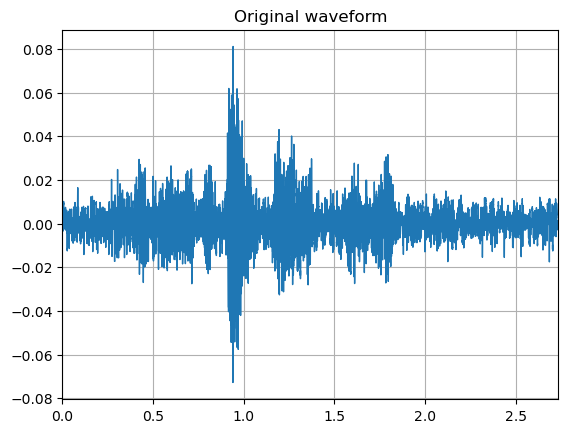

In [8]:
plot_waveform(waveform, sample_rate, title="Original waveform")

In [9]:
Audio(waveform.numpy(), rate=sample_rate)

### Transform

#### Resample

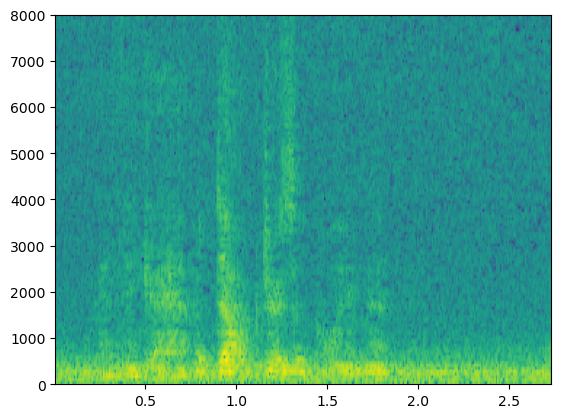

In [10]:
RESAMPLE_RATE = 16_000

resampler = transforms.Resample(sample_rate, RESAMPLE_RATE, dtype=waveform.dtype)
resampled_waveform = resampler(waveform)

resampled_specgram = plt.specgram(resampled_waveform[0].numpy(), Fs=RESAMPLE_RATE)

In [11]:
Audio(resampled_waveform.numpy(), rate=RESAMPLE_RATE)

#### Trim or Pad to ensure fixed length

In [12]:
def enforce_3_seconds(waveform: torch.Tensor, sample_rate: int) -> torch.Tensor:
    desired_length_seconds = 3
    desired_samples = int(desired_length_seconds * sample_rate)

    current_samples = waveform.shape[-1] # waveform.shape will be (channels, samples)

    if current_samples == desired_samples:
        return waveform
    elif current_samples > desired_samples:
        trimmed_waveform = waveform[..., :desired_samples]
        return trimmed_waveform
    else:
        padding_needed = desired_samples - current_samples
        # Create a tensor of zeros for padding, maintaining the number of channels
        padding = torch.zeros(waveform.shape[0], padding_needed, dtype=waveform.dtype)
        padded_waveform = torch.cat((waveform, padding), dim=-1)
        return padded_waveform

In [13]:
fixed_waveform = enforce_3_seconds(resampled_waveform, RESAMPLE_RATE)

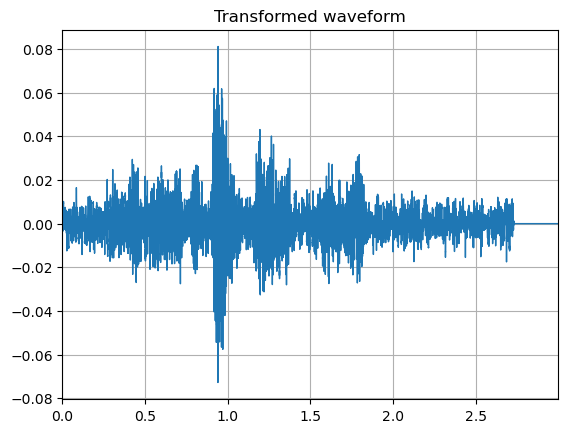

In [14]:
plot_waveform(fixed_waveform, RESAMPLE_RATE, title="Transformed waveform")

In [15]:
Audio(fixed_waveform.numpy(), rate=RESAMPLE_RATE)

#### Mel Spectogram

In [16]:
mel_transform = transforms.MelSpectrogram(
    RESAMPLE_RATE,  # Standard for speech
    n_fft=1024,  # Good frequency resolution
    n_mels=80,  # Sweet spot for speech emotions
    hop_length=256,  # ~16ms hop for speech
    win_length=1024,  # ~64ms window
    f_min=50,  # Remove very low frequencies
    f_max=8000,  # Focus on speech range)
)
mel_spectogram = mel_transform(fixed_waveform)

db_transform = transforms.AmplitudeToDB(
    stype="power"
)  # Use "power" since MelSpectrogram default power=2
mel_specgram_db = db_transform(mel_spectogram)

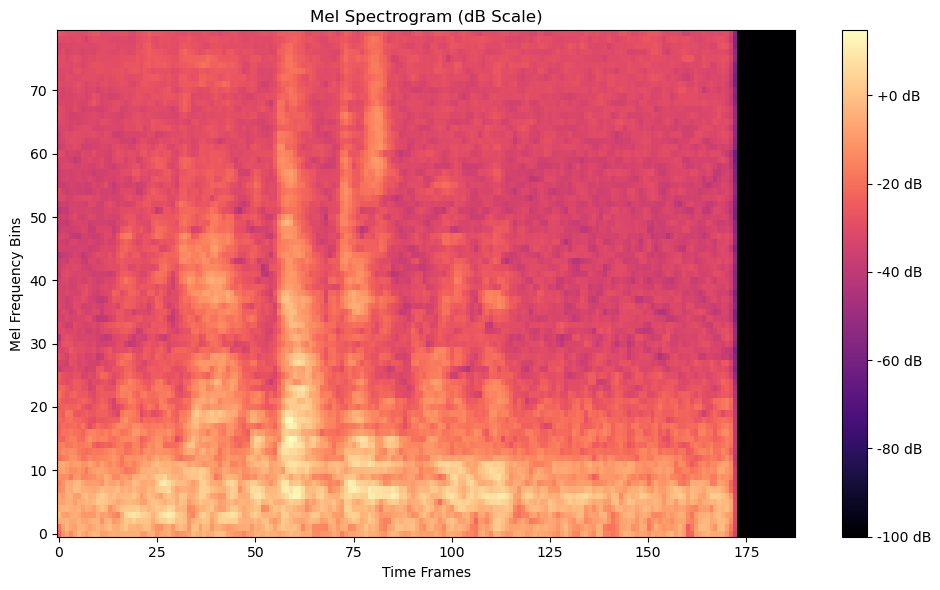

In [17]:
def plot_specgram(specgram):
    plt.figure(figsize=(10, 6))

    # Plot the Mel spectrogram in decibels
    # Convert the tensor to a NumPy array and remove the channel dimension
    # Use .squeeze() if you have a single channel, or select the channel if multiple
    plt.imshow(
        specgram.squeeze().numpy(),
        origin="lower",
        aspect="auto",
        cmap="magma",
        interpolation="nearest",
    )

    plt.title("Mel Spectrogram (dB Scale)")
    plt.xlabel("Time Frames")
    plt.ylabel("Mel Frequency Bins")
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout() # Adjusts plot to prevent labels from overlapping
    plt.show()

plot_specgram(mel_specgram_db)

### Stratified Train/Val/Test Split

In [18]:
classes = ["ANG", "DIS", "FEA", "HAP", "NEU", "SAD"]

def extract_emotion(sample_name):
    label = None
    for i, cls in enumerate(classes):
        if cls in sample_name:
            label = i
            break 

    if label is None:
        print(sample_name)

    return label

labels = [extract_emotion(sample_name) for sample_name in sample_names]

train_sample_names, temp_sample_names, train_labels, temp_labels = train_test_split(
    sample_names, labels, test_size=0.1, random_state=42, stratify=labels
)

val_sample_names, test_sample_names, val_labels, test_labels = train_test_split(
    temp_sample_names, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"Train samples: {len(train_sample_names)}")
print(f"Train samples: {len(val_sample_names)}")
print(f"Test samples: {len(test_sample_names)}")

Train samples: 6697
Train samples: 372
Test samples: 373


In [19]:
train_sample_names[0]

'1003_ITS_NEU_XX.wav'

In [20]:
train_labels[0]

4

In [21]:
def count_labels(labels):
    label_counts = collections.Counter()

    for label in labels:
        label_counts[label] += 1

    total_count = sum(label_counts.values())
    label_ratios = {label: count / total_count for label, count in label_counts.items()}
    
    sorted_label_ratios = dict(sorted(label_ratios.items()))

    return sorted_label_ratios

print(count_labels(train_labels))
print(count_labels(val_labels))
print(count_labels(test_labels))

{0: 0.17082275645811557, 1: 0.17082275645811557, 2: 0.17082275645811557, 3: 0.17067343586680603, 4: 0.14603553830073168, 5: 0.17082275645811557}
{0: 0.1693548387096774, 1: 0.17204301075268819, 2: 0.1693548387096774, 3: 0.17204301075268819, 4: 0.1478494623655914, 5: 0.1693548387096774}
{0: 0.17158176943699732, 1: 0.16890080428954424, 2: 0.17158176943699732, 3: 0.17158176943699732, 4: 0.1447721179624665, 5: 0.17158176943699732}


### Augmented data

In [22]:
class AudioAugmentation:
    """Audio-level augmentation techniques"""
    
    def __init__(self, sr=16000):
        self.sr = sr
        
    def add_noise(self, waveform, noise_factor=0.005):
        """Add Gaussian noise"""
        noise = torch.randn_like(waveform) * noise_factor
        return waveform + noise
    
    def time_shift(self, waveform, shift_limit=0.2):
        """Time shifting"""
        shift_amt = int(random.uniform(-shift_limit, shift_limit) * waveform.shape[1])
        return torch.roll(waveform, shift_amt, dims=1)
    
    def pitch_shift(self, waveform, n_steps=None):
        """Pitch shifting"""
        if n_steps is None:
            n_steps = random.uniform(-2, 2)
        
        # Simple pitch shifting using resampling
        factor = 2 ** (n_steps / 12)
        new_length = int(waveform.shape[1] / factor)
        
        # Resample
        resampled = torch.nn.functional.interpolate(
            waveform.unsqueeze(0), size=new_length, mode='linear', align_corners=False
        ).squeeze(0)
        
        # Pad or truncate to original length
        if resampled.shape[1] < waveform.shape[1]:
            pad_len = waveform.shape[1] - resampled.shape[1]
            resampled = torch.nn.functional.pad(resampled, (0, pad_len))
        else:
            resampled = resampled[:, :waveform.shape[1]]
        
        return resampled
    
    def speed_change(self, waveform, speed_factor=None):
        """Speed/tempo change"""
        if speed_factor is None:
            speed_factor = random.uniform(0.8, 1.2)
        
        new_length = int(waveform.shape[1] / speed_factor)
        
        # Resample
        resampled = torch.nn.functional.interpolate(
            waveform.unsqueeze(0), size=new_length, mode='linear', align_corners=False
        ).squeeze(0)
        
        # Pad or truncate to original length
        if resampled.shape[1] < waveform.shape[1]:
            pad_len = waveform.shape[1] - resampled.shape[1]
            resampled = torch.nn.functional.pad(resampled, (0, pad_len))
        else:
            resampled = resampled[:, :waveform.shape[1]]
        
        return resampled
    
    def volume_change(self, waveform, gain_db=None):
        """Volume/gain change"""
        if gain_db is None:
            gain_db = random.uniform(-10, 10)
        
        gain_factor = 10 ** (gain_db / 20)
        return waveform * gain_factor
    
    def apply_random_augmentation(self, waveform, prob=0.5):
        """Apply random augmentation with given probability"""
        augmentations = [
            self.add_noise,
            self.time_shift,
            self.pitch_shift,
            self.speed_change,
            self.volume_change
        ]
        
        augmented = waveform.clone()
        
        for aug in augmentations:
            if random.random() < prob:
                try:
                    augmented = aug(augmented)
                except:
                    continue  # Skip if augmentation fails
        
        return augmented

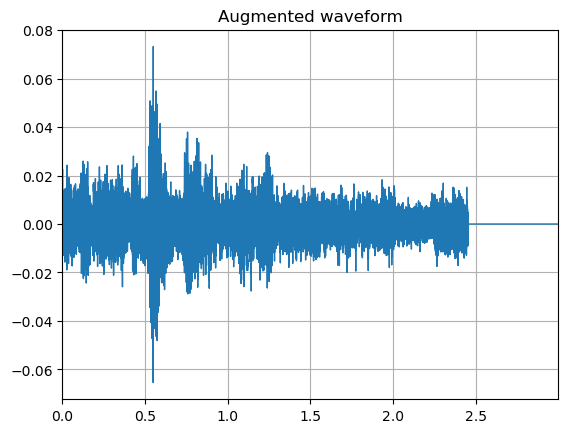

In [23]:
augmented_waveform = AudioAugmentation(RESAMPLE_RATE).apply_random_augmentation(fixed_waveform, prob=1.0)
plot_waveform(augmented_waveform, RESAMPLE_RATE, title="Augmented waveform")
Audio(augmented_waveform.numpy(), rate=RESAMPLE_RATE)

In [24]:
class SpectrogramAugmentation:
    """Spectrogram-level augmentation techniques"""
    
    def __init__(self):
        pass
    
    def freq_mask(self, spectrogram, freq_mask_param=15, num_masks=1):
        """Frequency masking (SpecAugment)"""
        spec = spectrogram.clone()
        for _ in range(num_masks):
            f = random.randint(0, freq_mask_param)
            f0 = random.randint(0, spec.shape[-2] - f)
            spec[..., f0:f0+f, :] = 0
        return spec
    
    def time_mask(self, spectrogram, time_mask_param=25, num_masks=1):
        """Time masking (SpecAugment)"""
        spec = spectrogram.clone()
        for _ in range(num_masks):
            t = random.randint(0, time_mask_param)
            t0 = random.randint(0, spec.shape[-1] - t)
            spec[..., :, t0:t0+t] = 0
        return spec
    
    def mixup_spectrogram(self, spec1, spec2, alpha=0.2):
        """Mixup augmentation for spectrograms"""
        if random.random() > 0.5:
            lam = np.random.beta(alpha, alpha)
            mixed_spec = lam * spec1 + (1 - lam) * spec2
            return mixed_spec, lam
        return spec1, 1.0
    
    def apply_spec_augment(self, spectrogram, prob=0.8):
        """Apply SpecAugment with given probability"""
        if random.random() < prob:
            # Apply frequency masking
            spectrogram = self.freq_mask(spectrogram)
            # Apply time masking
            spectrogram = self.time_mask(spectrogram)
        return spectrogram

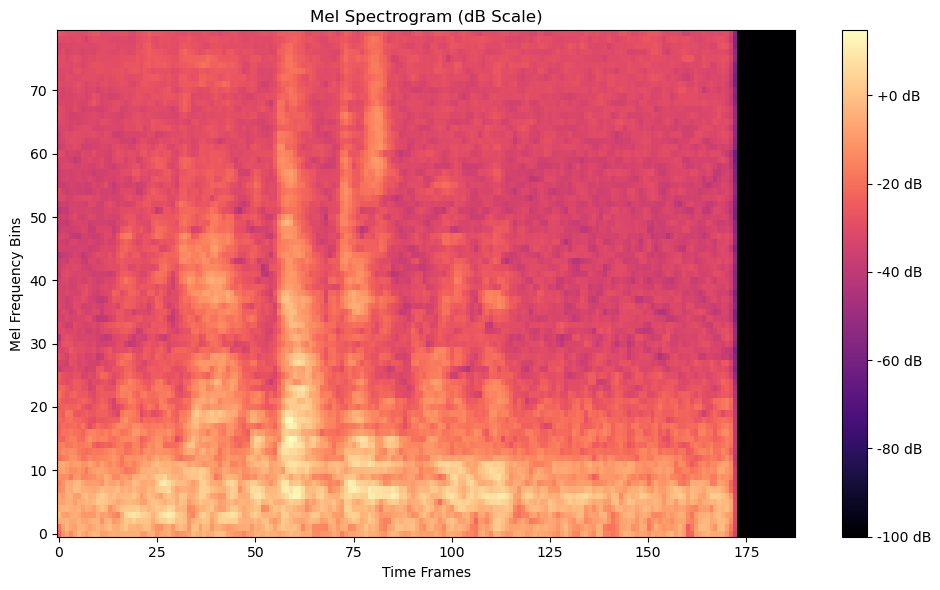

In [25]:
augmented_mel_specgram_db = SpectrogramAugmentation().apply_spec_augment(mel_specgram_db, prob=1.0)

plot_specgram(mel_specgram_db)

### Datasets

In [26]:
class EmotionalAudioDataset(Dataset):
    def __init__(self, sample_names, labels, use_augmented_data=False):
        self.sample_names = sample_names
        self.sample_names_len = len(self.sample_names)
        self.labels = labels
        self.use_augmented_data = use_augmented_data
        self.audio_augment = AudioAugmentation(RESAMPLE_RATE)
        self.spec_augment = SpectrogramAugmentation()

    def __len__(self):
        if (self.use_augmented_data):
            return self.sample_names_len * 2
        else:
            return self.sample_names_len

    def __getitem__(self, idx):
        augmented = False
        if (idx >= self.sample_names_len):        
            augmented = True
            idx -= self.sample_names_len

        sample_name = self.sample_names[idx]
        label = self.labels[idx]

        sample_path = os.path.join(ROOT_DIR, sample_name)
        waveform, sample_rate = torchaudio.load(sample_path)

        resampler = transforms.Resample(sample_rate, RESAMPLE_RATE, dtype=waveform.dtype)
        resampled_waveform = resampler(waveform)

        fixed_waveform = enforce_3_seconds(resampled_waveform, RESAMPLE_RATE)

        if (augmented):
            fixed_waveform = self.audio_augment.apply_random_augmentation(fixed_waveform, prob=0.3)

        mel_transform = transforms.MelSpectrogram(
            RESAMPLE_RATE,  # Standard for speech
            n_fft=1024,  # Good frequency resolution
            n_mels=80,  # Sweet spot for speech emotions
            hop_length=256,  # ~16ms hop for speech
            win_length=1024,  # ~64ms window
            f_min=50,  # Remove very low frequencies
            f_max=8000,  # Focus on speech range)
        )
        mel_spectogram = mel_transform(fixed_waveform)

        db_transform = transforms.AmplitudeToDB(
            stype="power"
        )  # Use "power" since MelSpectrogram default power=2
        sample = db_transform(mel_spectogram)

        if (augmented):
            sample = self.spec_augment.apply_spec_augment(sample, prob=0.7)

        return sample, label

In [27]:
train_dataset = EmotionalAudioDataset(train_sample_names, train_labels, use_augmented_data=True)
val_dataset = EmotionalAudioDataset(val_sample_names, val_labels)
test_dataset = EmotionalAudioDataset(test_sample_names, test_labels)

In [28]:
next(iter(train_dataset))[0].shape

torch.Size([1, 80, 188])

### Dataloader

In [29]:
# Preserves reproducibility
# https://docs.pytorch.org/docs/stable/notes/randomness.html
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)

In [30]:
train_dataloader = DataLoader(
    train_dataset,
    params["batch_size"],
    shuffle=True,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g,
)
val_dataloader = DataLoader(
    val_dataset,
    params["batch_size"],
    shuffle=False,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g,
)
test_dataloader = DataLoader(
    test_dataset,
    params["batch_size"],
    shuffle=False,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g,
)

In [31]:
next(iter(train_dataloader))[0].shape

torch.Size([64, 1, 80, 188])

## Model

In [32]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(4, 4),
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1)
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(640, len(classes))
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)

        x = torch.flatten(x, start_dim=1)
        
        # Classification
        x = self.classifier(x)
        return x

## Training

### Learning Rate range test

Goal is to find min and max LR for Cyclical Learning Rates - One Cycle policy: https://arxiv.org/pdf/1506.01186

In [33]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device

        # Store initial state to restore later
        self.model_state = model.state_dict()
        self.optimizer_state = optimizer.state_dict()

    def range_test(self, dataloader, start_lr=1e-7, end_lr=10, num_iter=100, smooth_f=0.05, diverge_th=5):
        self.lrs = []
        self.losses = []
        best_loss = float('inf')
        avg_loss = 0.
        
        # Exponentially increase learning rate
        lr_lambda = lambda x: np.exp(x * np.log(end_lr / start_lr) / num_iter)
        scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda)

        # Move model to device
        self.model.to(self.device)
        self.model.train()

        i = 0
        iterator = iter(dataloader)
        while(True):
            try:
                inputs, labels = next(iterator)
            except StopIteration:
                iterator = iter(dataloader)
                inputs, labels = next(iterator)

            if i >= num_iter:
                break

            inputs, labels = inputs.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)

            # Record learning rate and loss
            new_lr = self.optimizer.param_groups[0]['lr']
            self.lrs.append(new_lr)
            new_loss = loss.item()
            self.losses.append(new_loss)

            # Update loss for smoothing and divergence check
            avg_loss = smooth_f * loss.item() + (1 - smooth_f) * avg_loss
            if i == 0:
                best_loss = loss.item()
            else:
                best_loss = min(best_loss, loss.item())

            if (i % 100 == 0):
                print(new_lr, new_loss)

            # Check for divergence
            if i > 1 and avg_loss > diverge_th * best_loss:
                print(f"Stopping early, loss diverged at LR: {self.optimizer.param_groups[0]['lr']:.2e}")
                break

            loss.backward()
            self.optimizer.step()
            scheduler.step()

            i += 1

        # Restore model and optimizer to initial state
        self.model.load_state_dict(self.model_state)
        self.optimizer.load_state_dict(self.optimizer_state)

        return self.lrs, self.losses

    def plot(self, skip_start=10, skip_end=5, log_lr=True):
        if not self.lrs or not self.losses:
            print("Run range_test() first!")
            return

        lrs = self.lrs[skip_start:-skip_end] if skip_end > 0 else self.lrs[skip_start:]
        losses = self.losses[skip_start:-skip_end] if skip_end > 0 else self.losses[skip_start:]

        fig, ax = plt.subplots(1, 1)
        ax.plot(lrs, losses)
        ax.set_xlabel("Learning Rate")
        ax.set_ylabel("Loss")
        if log_lr:
            ax.set_xscale('log')
        plt.show()

In [34]:
rerun_lr_test = False
if rerun_lr_test:
    start_lr = 1e-8
    end_lr = 10
    num_iter = 1000

    # Keep same as training code
    model = NeuralNetwork().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=start_lr)

    lr_finder = LRFinder(model, optimizer, loss_fn, device)

    lrs, losses = lr_finder.range_test(train_dataloader, start_lr, end_lr, num_iter) 

    lr_finder.plot()

### Train and Eval loops

In [35]:
def train_loop(device, dataloader, model, loss_fn, optimizer, lr_scheduler):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    train_loss /= num_batches
    accuracy = 100.0 * correct / size

    return train_loss, accuracy

In [36]:
def eval_loop(device, dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    accuracy = 100.0 * correct / size

    return loss, accuracy

### Early Stopping

In [37]:
class EarlyStopping:

    def __init__(
        self, patience=7, verbose=False, delta=0, path="checkpoint.pt", trace_func=print
    ):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = np.Inf
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        if val_loss + self.delta >= self.best_loss :
            self.counter += 1
            self.trace_func(
                f"EarlyStopping counter: {self.counter} out of {self.patience}"
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.counter = 0

        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

    def load_checkpoint(self, model):
        model.load_state_dict(torch.load(self.path))

### Training and Validation

In [38]:
mlflow.start_run()
mlflow.log_params(params)

In [39]:
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=params["base_lr"])
lr_scheduler = OneCycleLR(
    optimizer,
    max_lr=params["max_lr"],
    steps_per_epoch=len(train_dataloader),
    epochs=params["epochs"],
)
early_stopping = EarlyStopping(patience=10, delta=1e-2, verbose=True)

with open("model_summary.txt", "w") as f:
    # Get the shape of a batch (including batch size)
    batch = next(iter(train_dataloader))[0]
    input_size = batch.shape  # (batch_size, channels, n_mels, time)
    f.write(str(summary(model, input_size=input_size)))
mlflow.log_artifact("model_summary.txt")

In [40]:
history = {"train_loss": [], "val_loss": []}
best_val_acc = 0.0

for epoch in range(params["epochs"]):
    print(f"\nEpoch {epoch+1}\n-------------------------------")
    train_loss, train_acc = train_loop(
        device, train_dataloader, model, loss_fn, optimizer, lr_scheduler
    )
    val_loss, val_acc = eval_loop(device, val_dataloader, model, loss_fn)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    mlflow.log_metrics(
        {
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
        },
        step=epoch,
    )

    print(f"Train: \n Accuracy: {train_acc:>0.1f}%, Avg loss: {train_loss:>8f} \n")
    print(f"Validation: \n Accuracy: {val_acc:>0.1f}%, Avg loss: {val_loss:>8f} \n")

    # Early stopping check
    early_stopping(val_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print("Done!")

print("Restoring best model")
early_stopping.load_checkpoint(model)


Epoch 1
-------------------------------
Train: 
 Accuracy: 36.9%, Avg loss: 1.533680 

Validation: 
 Accuracy: 44.9%, Avg loss: 1.408847 

Validation loss decreased (inf --> 1.408847).  Saving model ...

Epoch 2
-------------------------------
Train: 
 Accuracy: 44.0%, Avg loss: 1.391484 

Validation: 
 Accuracy: 49.7%, Avg loss: 1.317585 

Validation loss decreased (1.408847 --> 1.317585).  Saving model ...

Epoch 3
-------------------------------
Train: 
 Accuracy: 47.9%, Avg loss: 1.322323 

Validation: 
 Accuracy: 54.0%, Avg loss: 1.213651 

Validation loss decreased (1.317585 --> 1.213651).  Saving model ...

Epoch 4
-------------------------------
Train: 
 Accuracy: 49.1%, Avg loss: 1.280166 

Validation: 
 Accuracy: 53.2%, Avg loss: 1.183560 

Validation loss decreased (1.213651 --> 1.183560).  Saving model ...

Epoch 5
-------------------------------
Train: 
 Accuracy: 51.4%, Avg loss: 1.243507 

Validation: 
 Accuracy: 55.1%, Avg loss: 1.184049 

EarlyStopping counter: 1 out 

In [41]:
X = next(iter(train_dataloader))[0]

signature = infer_signature(X.numpy(), model(X.to(device)).detach().cpu().numpy())
model_info = mlflow.pytorch.log_model(model, artifact_path="mlmodel", signature=signature)

2025/06/26 18:23:39 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0.dev20250205+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.7.0.dev20250205' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/26 18:23:44 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0.dev20250205+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.7.0.dev20250205' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


### Learning Curves

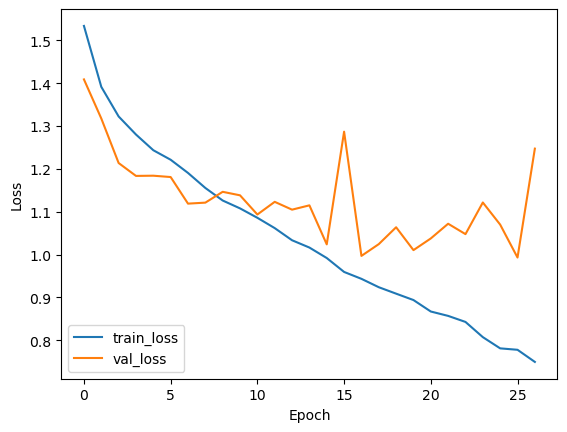

In [42]:
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="lower left")

## Evaluation

In [43]:
model.eval()

y_true = []
for _, y in test_dataloader:
    y_true.extend(y.tolist())

test_loss = 0
y_pred = []
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)

        pred = model(X)

        test_loss += loss_fn(pred, y).item()
        y_pred.extend(pred.argmax(1).detach().cpu().numpy())

test_loss /= len(test_dataloader)
test_accuracy = accuracy_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred, average="weighted")

mlflow.log_metrics(
    {
        "test_loss": test_loss,
        "test_accuracy": test_accuracy,
        "test_weighted_f1": test_f1,
    }
)

print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)
print("F1 (weighted) score: ", test_f1)

Test loss:  0.8646904130776724
Test accuracy:  0.6648793565683646
F1 (weighted) score:  0.6609711434243503


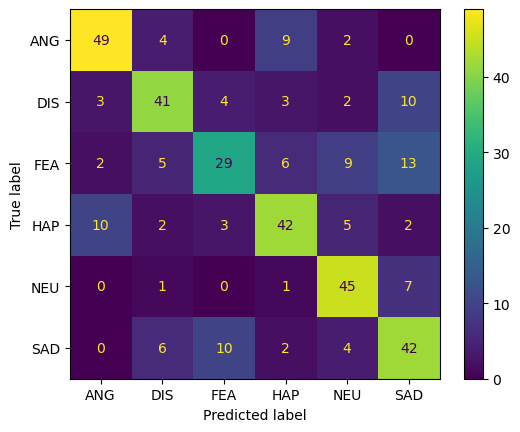

In [44]:
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=classes)
cm_display.plot()
plt.show()

In [45]:
# Predictions with MLFlow API (for deployment)
X, y_true = next(iter(test_dataloader))
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)
predictions = loaded_model.predict(X.numpy()).argmax(1)
print("Test accuracy:", accuracy_score(y_true, predictions))

Test accuracy: 0.640625


In [46]:
# Convert numpy output to torch tensor before applying softmax
logits = loaded_model.predict(X.numpy())
probs = nn.functional.softmax(torch.from_numpy(logits), dim=1)
probs

tensor([[1.9805e-01, 2.9900e-01, 5.6005e-02, 3.2912e-01, 1.0439e-01, 1.3439e-02],
        [1.1761e-02, 4.1016e-02, 1.6273e-02, 2.3943e-01, 6.2834e-01, 6.3183e-02],
        [1.4547e-03, 5.8299e-02, 9.2619e-02, 7.4268e-03, 5.8262e-02, 7.8194e-01],
        [7.0319e-01, 2.0051e-01, 2.8780e-02, 3.5548e-02, 1.2209e-02, 1.9769e-02],
        [5.0409e-03, 2.5954e-01, 1.3195e-01, 1.4598e-01, 8.8580e-02, 3.6891e-01],
        [7.8782e-01, 4.0490e-02, 3.8028e-02, 1.2163e-01, 8.7470e-03, 3.2925e-03],
        [4.8237e-03, 8.6841e-02, 2.3911e-01, 1.9878e-02, 4.3204e-02, 6.0615e-01],
        [9.7191e-02, 2.2663e-02, 6.7534e-03, 2.5586e-02, 8.2188e-01, 2.5932e-02],
        [1.4276e-05, 4.0435e-02, 6.2213e-01, 1.0986e-03, 1.8109e-04, 3.3615e-01],
        [6.5753e-04, 1.2470e-02, 2.8514e-01, 2.2291e-02, 3.4826e-02, 6.4462e-01],
        [6.9300e-03, 6.1795e-01, 1.4018e-01, 5.9885e-02, 3.5241e-02, 1.3981e-01],
        [8.3170e-01, 1.2564e-01, 4.8761e-04, 4.1927e-02, 1.8494e-04, 6.4611e-05],
        [1.8023e

In [47]:
mlflow.end_run()

🏃 View run bittersweet-mule-310 at: http://127.0.0.1:8080/#/experiments/720088859882911667/runs/856cd773c9cd47e2a240a4bd5afdc6dd
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/720088859882911667


## Playground